# DMFT with IPT solver
Author: [Niklas Witt](mailto:niklas.witt@physik.uni-hamburg.de)

In this tutorial, we will implement the Dynamical Mean-Field Theory (DMFT) using the iterative perturbation theory (IPT) as a solver for the impurity problem [1]. It is assumed that the reader is somewhat familiar with the concept of DMFT and the Anderson impurity model. Good resources to learn about this topic can be found, e.g., in Refs. [2-4].

## Theory

### Model
We compute a paramagnetic solution assuming the non-interacting semi-circular density of state (Bethe lattice)

$$
 \rho(\omega) = \frac{\sqrt{4t_\star^2-\omega^2}}{2\pi t_\star^2 } = 2\frac{\sqrt{D^2-\omega^2}}{\pi D^2}.
$$

at half filling. We set the hopping $t_\star=1$, so that the half bandwitdh is $D=2t_\star = 2$.  Our goal is to find the Mott transition in this model. The non-interacting, local Green function is given by the spectral representation 

$$
    G^0_{\mathrm{loc}}(i\omega_n) = \int d\omega \frac{\rho(\omega)}{i\omega_n-\omega}, 
$$

with fermionic Matsubara frequencies $\omega_n=(2n+1)\pi T$. We can directly compute this equation with the IR basis.

### DMFT equations
In DMFT, the self-energy is approximated by the local solution of an impurity model. The self-consistent equations to be solved are the Dyson equation of the interacting local Green function $G_{\mathrm{loc}}$

$$ 
    G^{-1}_{\mathrm{loc}}(i\omega_n) = \mathcal{G}^{-1}(i\omega_n) - \Sigma(i\omega_n)
$$

with the self-energy $\Sigma$ (from the impurity problem) and the cavity Green function/Weiss field $\mathcal{G}$ as well as the mean-field mapping for the Bethe lattice [2]

$$
    \mathcal{G}^{-1}(i\omega_n) = i\omega_n - t_\star^2  G_{\mathrm{loc}}(i\omega_n),
$$

for which the impurity problem needs to be solved. As a starting point we put in $G^0_{\mathrm{loc}}(i\omega_n)$ into the latter equation.


### IPT Solver
The IPT is an inexpensive way of solving the impurity problem (instead of applying e.g. Quantum Monte Carlo (QMC) or Exact Diagonalization (ED) methods). The self-energy is approximated by the second-order perturbation theory (SOPT/GF2, see other [tutorial](second_order_perturbation_py.md))

$$
    \Sigma(\tau) = U^2\mathcal{G}^3(\tau).
$$

with the Hubbard interaction $U$ and imaginary time $\tau$. Note that we absorbed the constant Hartree term $\Sigma_H = U n_{\sigma} = U\frac{n}{2}$ into the definition of the chemical potential $\mu$ (at half filling, it is shifted to zero). Otherwise we would have to treat this term separately, since the IR basis cannot model the $\delta$-peak in frequency space well/compactly. In this case, evaluate the term analytically and add it after the Fourier transformation step.

### Renormalization factor

The Mott transition can be detected by monitoring the renormalization factor

$$
Z = \frac{1}{1-\frac{\partial \mathrm{Re} \Sigma(\omega+i0^+)}{\partial \omega}}\Big|_{\omega=0} \approx \frac{1}{1 - \frac{\mathrm{Im}\{\Sigma(i\omega_1)-\Sigma(i\omega_0)\}}{\omega_1 - \omega_0 }} .
$$

In the non-interacting limit $U\rightarrow 0$ we have $Z\rightarrow 1$. Correlation effects reduce $Z$ as $Z < 1$ and the Mott transition is signaled by a jump $Z\to0$.

[1] A. Georges and G. Kotliar, Phys. Rev. B 45, 6479 (1992)

[2] A. Georges et al., Rev. Mod. Phys. 68, 13 (1996)

[3] Many book chapters of the Jülich autumn school series, see https://www.cond-mat.de/events/correl.html

[4] R. M. Martin, L. Reining, D. M. Ceperley, Interacting Electrons, Cambridge University Press (2016)

#### Notes on practical implementation
* We will try to find the Mott transition which is a phase transition of first order. To illustrate this, we will do calculations starting from the metallic and the insulating phase at the end of this tutorial. This will show a hysteresis, signaling the metastable/coexistence region of both solutions. For converged results, this will need many iteration steps.
* In the insulating phase, the low-frequency part of the self-energy turns downwards and diverges. Using the above formula for calculating the renormalization factor $Z$ from a linearized self-energy, it would be negative. To circumvent this unphysical notion, $Z$ then is defined as zero in the implementation.
* We include a mixing $p<1$ in each iteration step, such that the Green function of step $n+1$ is partially constructed from the old and new Green function as $G^{n+1} = p\,G^{n+1} + (1-p)\,G^{n}$. This smoothes too strong oscillations of the solution which is important especially near the phase transition point.

## Code implementation

In [1]:
import numpy as np
import scipy as sc
import scipy.optimize
from warnings import warn
import sparse_ir
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# Get sparse-ir version
try:
    from importlib.metadata import version
    sparse_ir_version = version('sparse-ir')
except ImportError:
    try:
        import pkg_resources
        sparse_ir_version = pkg_resources.get_distribution('sparse-ir').version
    except:
        sparse_ir_version = "unknown"

print(f"sparse-ir version: {sparse_ir_version}")

sparse-ir version: 2.0.0a8


### Setting up the solver

#### Generating meshes
We need to generate IR basis functions on a sparse $\tau$ and $i\omega_n$ grid. In addition, we set calculation routines to Fourier transform $\tau\leftrightarrow i\omega_n$ (via IR basis).

In [2]:
# Initiate fermionic and bosonic IR basis objects by using (later):
# IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
class Mesh:
    """
    Holding class for sparsely sampled imaginary time 'tau' / Matsubara frequency 'iwn' grids.
    Additionally it defines the Fourier transform via 'tau <-> l <-> wn'.
    """
    def __init__(self,IR_basis_set):
        self.IR_basis_set = IR_basis_set

        # lowest Matsubara frequency index
        self.iw0_f = np.where(self.IR_basis_set.wn_f == 1)[0][0]
        self.iw0_b = np.where(self.IR_basis_set.wn_b == 0)[0][0]

        # frequency mesh (for plotting Green function/self-energy)
        self.iwn_f = 1j * self.IR_basis_set.wn_f * np.pi * T

    def smpl_obj(self, statistics):
        """ Return sampling object for given statistic """
        smpl_tau = {'F': self.IR_basis_set.smpl_tau_f, 'B': self.IR_basis_set.smpl_tau_b}[statistics]
        smpl_wn  = {'F': self.IR_basis_set.smpl_wn_f,  'B': self.IR_basis_set.smpl_wn_b }[statistics]
        return smpl_tau, smpl_wn

    def tau_to_wn(self, statistics, obj_tau):
        """ Fourier transform from tau to iwn via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_l   = smpl_tau.fit(obj_tau, axis=0)
        obj_wn  = smpl_wn.evaluate(obj_l, axis=0)
        return obj_wn

    def wn_to_tau(self, statistics, obj_wn):
        """ Fourier transform from iwn to tau via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_l   = smpl_wn.fit(obj_wn, axis=0)
        obj_tau = smpl_tau.evaluate(obj_l, axis=0)
        return obj_tau

#### IPT solver
We write a function for the IPT solver. We use the `Mesh` class defined above to perform calculation steps.

In [3]:
def IPTSolver(mesh, g_weiss, U):
    """
    IPT solver to calculate the impurity problem.
    Input:
        mesh - Holding class of IR basis with sparsely sampled grids.
        g_weiss - Weiss field of the bath (\mathcal(G); cavity Green function)
                  on Matsubara frequencies iwn.
        U - Hubbard interaction strength
    """

    # Fourier transform to imaginary time
    gtau = mesh.wn_to_tau('F', g_weiss)

    # Self-energy in SOPT
    sigma = U**2 * gtau**3

    # Fourier transform back to Matsubara frequency
    sigma = mesh.tau_to_wn('F', sigma)
    return sigma

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/y9/xh94fvpd2hl50zs024hhjl180000gn/T/ipykernel_97568/390228342.py:6: SyntaxWarning: invalid escape sequence '\m'
  g_weiss - Weiss field of the bath (\mathcal(G); cavity Green function)


#### DMFT loop
We wrap the DMFT loop in a class that sets all necessary quantities when initializing and runs when calling the `.solve` instance.

In [4]:
class DMFT_loop:
    def __init__(self,mesh, g0_loc, U, D, sfc_tol=1e-4, maxiter=20, mix=0.2,
                  verbose=True):

        # Set input
        self.mesh = mesh
        self.U = U
        self.t = D/2
        self.mix = mix
        self.sfc_tol = sfc_tol
        self.maxiter = maxiter
        self.verbose = verbose

        # Initial Green function (e.g. non-interacting)
        self.g_loc = g0_loc

        # Initiate Weiss field
        self.sigma = 0
        self.calc_g_weiss()

    def solve(self):
        for it in range(self.maxiter):
            sigma_old = self.sigma

            # Solve impurity problem in IPT
            sigma = IPTSolver(self.mesh, self.g_weiss, self.U)
            self.sigma = sigma*self.mix + self.sigma*(1-self.mix)

            # Set new Green function and Weiss field
            self.calc_g_loc()
            self.calc_g_weiss()

            # Check whether solution is converged
            sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))
            if self.verbose:
                print(it, sfc_check)
            if sfc_check < self.sfc_tol:
                if self.verbose:
                    print("DMFT loop converged at desired accuracy of", self.sfc_tol)
                break

    def calc_g_loc(self):
        # Set interacting local Green function from Dyson's equation.
        self.g_loc = (self.g_weiss**(-1) - self.sigma)**(-1)

    def calc_g_weiss(self):
        # Calculate Weiss mean field of electron bath.
        self.g_weiss = (self.mesh.iwn_f - self.t**2 * self.g_loc)**(-1)
        #self.g_weiss = (self.g_loc**(-1) + self.sigma)**(-1)

### Calculations

#### Parameter setting

In [5]:
### System parameters
D    = 2      # half bandwidth D = W/2 ; hopping t = 1 here
wmax = 2*D    # set wmax >= W = 2*D
T    = 0.1/D  # temperature
beta = 1/T    # inverse temperature
U    = 5.     # Hubbard interaction

### Numerical parameters
IR_tol  = 1e-15  # desired accuracy for l-cutoff of IR basis functions
maxiter = 300    # maximal number of DMFT convergence steps
sfc_tol = 1e-5   # desired accuracy of DMFT convergence
mix     = 0.25   # mixing factor

In [6]:
### Initialize calculation
# Set mesh
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
mesh = Mesh(IR_basis_set)

# Calculate non-interacting Green function
rho = lambda omega : 2*np.sqrt(D**2 - np.clip(omega, -D, D)**2)/(np.pi*D**2)
rho_l = IR_basis_set.basis_f.v.overlap(rho)
g0_l  = -IR_basis_set.basis_f.s * rho_l
g0_loc = IR_basis_set.smpl_wn_f.evaluate(g0_l)

# Initiate DMFT loop
solver = DMFT_loop(mesh, g0_loc, U, D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=True)

# perform DMFT calculations
solver.solve()

0 1.0
1 0.4526728310655137
2 0.2649342583733908
3 0.17712687187234707
4 0.12505927813194564
5 0.09230110659868546
6 0.06978888596161428
7 0.053933689537265815
8 0.0422708752105843
9 0.03356908333379566
10 0.026917670940404915
11 0.021779884933620743
12 0.017752764285708104
13 0.01456898536615962
14 0.012027100298184226
15 0.009982968108466482
16 0.008327026629379156
17 0.00697725514362107
18 0.0058705010792359695
19 0.004958162343366907
20 0.004202295886831823
21 0.003573152603216805
22 0.0030472027397398767
23 0.002605735672401597
24 0.0022337760198429197
25 0.001919274201617248
26 0.0016524816303133414
27 0.0014254718150511954
28 0.0012317680873841878
29 0.0010660537363283568
30 0.0009239445618913701
31 0.0008018097036934632
32 0.000696629714444516
33 0.0006058836421112194
34 0.0005274587631660864
35 0.00045957810577479136
36 0.0004007419977180595
37 0.00034968072181858933
38 0.0003053160037795471
39 0.00026672955293899835
40 0.0002331372577349337
41 0.00020386793336659806
42 0.00017

#### Visualize results

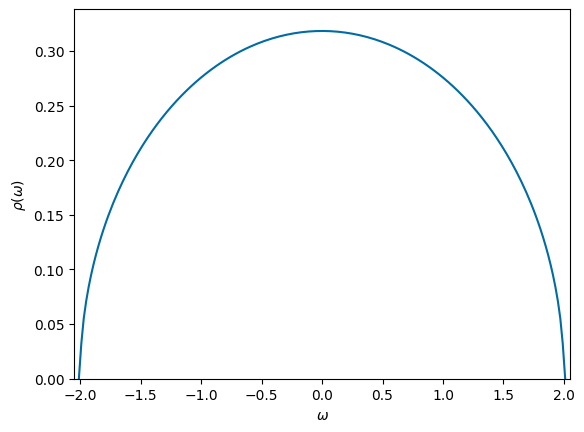

In [7]:
# Plot spectral function/density of states
omega = np.linspace(-D-0.01, D+0.01,200)
plt.plot(omega, rho(omega),'-')
ax = plt.gca()
ax.set_xlim([-D-0.05,D+0.05])
ax.set_ylim([0,2/np.pi/D+0.02])
ax.set_xlabel('$\\omega$')
ax.set_ylabel('$\\rho(\\omega)$')
plt.show()

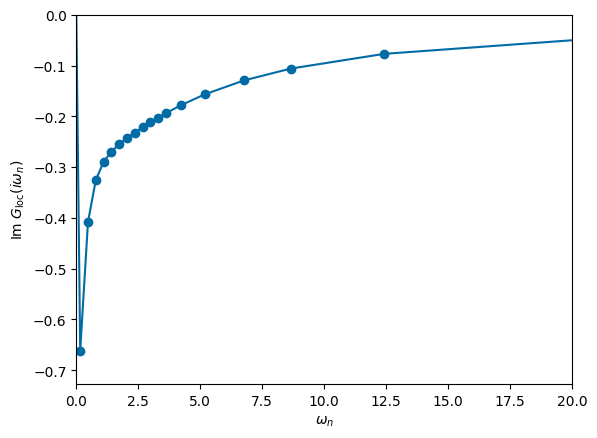

In [8]:
# plot frequency dependence of Green function
plt.plot(np.imag(mesh.iwn_f), np.imag(solver.g_loc),'-o')
ax = plt.gca()
ax.set_xlabel('$\\omega_n$')
ax.set_xlim([0,20])
ax.set_ylabel('Im $G_{\\mathrm{loc}}(i\\omega_n)$')
ax.set_ylim(ymax=0)
plt.show()

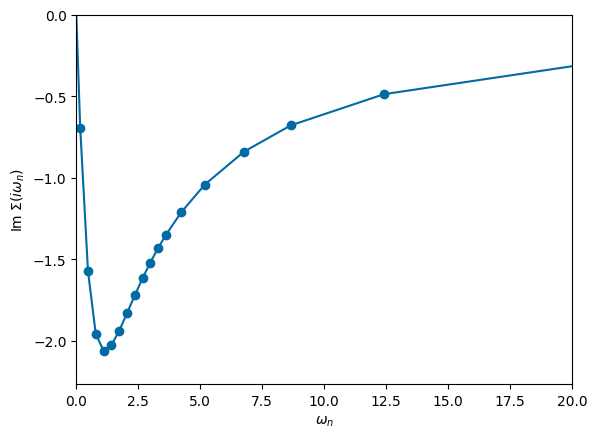

In [9]:
# plot frequency dependence of self-energy
plt.plot(np.imag(mesh.iwn_f), np.imag(solver.sigma),'-o')
ax = plt.gca()
ax.set_xlabel('$\\omega_n$')
ax.set_xlim([0,20])
ax.set_ylabel('Im $\\Sigma(i\\omega_n)$')
ax.set_ylim(ymax=0)
plt.show()

### Renormalization factor
We calculate the renormalization factor from a linearized self-energy. It is also possible to approximate it from the lowest Matsubara frequency (see and try out the difference!).

In [10]:
def CalcRenormalizationZ(solver):
    sigma = solver.sigma
    sigma_iw0 = sigma[solver.mesh.iw0_f]
    sigma_iw1 = sigma[solver.mesh.iw0_f+1]
    beta = solver.mesh.IR_basis_set.beta
    Z = 1/(1 - np.imag(sigma_iw1 - sigma_iw0)*beta/(2*np.pi))
    #Z = 1/(1 - np.imag(sigma_iw0)*beta/np.pi)

    # When system turns insulating, slope becomes positive/Z becomes negative -> set Z to zero then
    if Z < 0:
        Z = 0
    return Z

Now we perform calculations for different $U$ to find the Mott transition. To see the evolution, we also plot the self-energy for some $U$ values.

/var/folders/y9/xh94fvpd2hl50zs024hhjl180000gn/T/ipykernel_97568/5493488.py:34: RuntimeWarning: invalid value encountered in scalar divide
  sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))


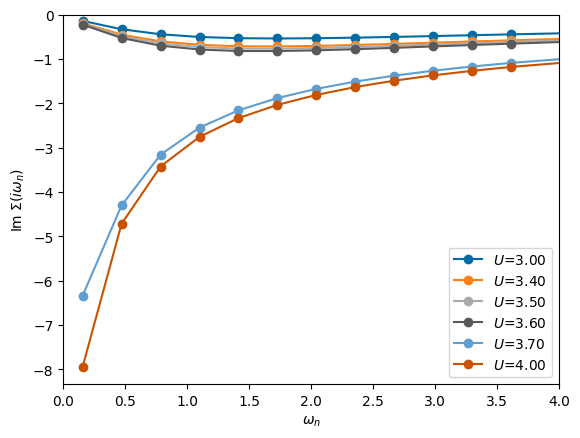

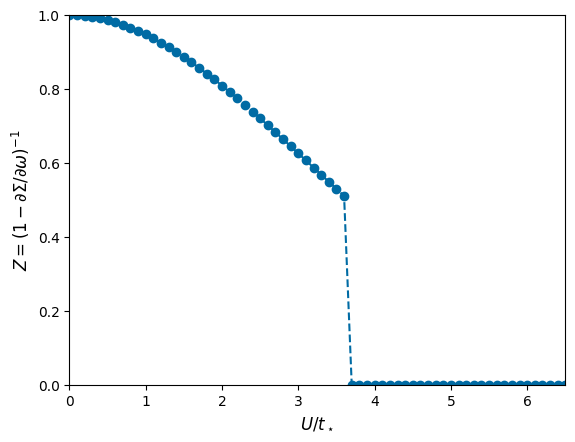

In [11]:
# Set U values as unit of t
U_min = 0
U_max = 6.5
U_num = 66
U_arr = np.linspace(U_min, U_max, U_num)
Z_arr = np.empty(U_arr.shape)

# Set new convergence parameters to achieve good convergence near the phase transition line
maxiter = 1500    # maximal number of DMFT convergence steps
sfc_tol = 1e-14   # desired accuracy of DMFT convergence


# Set mesh
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
mesh = Mesh(IR_basis_set)

# Calculate noninteracting Green function
rho = lambda omega : np.sqrt(D**2 - np.clip(omega, -D, D)**2)/(np.pi*D)
rho_l = IR_basis_set.basis_f.v.overlap(rho)
g0_l  = -IR_basis_set.basis_f.s * rho_l
g0_loc = IR_basis_set.smpl_wn_f.evaluate(g0_l)


plt.figure()
for it, U in enumerate(U_arr):
    # Starting from non-interacting solution
    solver = DMFT_loop(mesh, g0_loc, U, D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
    solver.solve()
    Z = CalcRenormalizationZ(solver)
    Z_arr[it] = Z

    if it in [30, 34, 35, 36, 37, 40]:
        plt.plot(np.imag(mesh.iwn_f[mesh.iw0_f:]), np.imag(solver.sigma[mesh.iw0_f:]),'-o', label='$U$={:.2f}'.format(U))


ax = plt.gca()
ax.set_xlabel('$\\omega_n$')
ax.set_xlim([0,4])
ax.set_ylabel('Im $\\Sigma(i\\omega_n)$')
ax.set_ylim(ymax=0)
ax.legend()

#%%%%%%%%%%%%%%%% Plot results
plt.figure()
plt.plot(U_arr, Z_arr, '--o')
ax = plt.gca()
ax.set_xlabel('$U/t_\\star$', fontsize=12)
ax.set_xlim([U_min, U_max])
ax.set_ylabel(r'$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
ax.set_ylim([0,1])
plt.show()

You can quite well see a jump of $Z$ between $U/t_\star=3$ and 4 which is accompanied by the low-frequency part of the self-energy diverging instead of going to zero.

In a last step, we want to map out the metastable coexistence region. In order to do this, we have to start every new $U$ calculation from the previous converged solution. If we start from small $U$, we start from the metallic region, whereas starting from large $U$ corresponds to starting from the insulating solution.

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/var/folders/y9/xh94fvpd2hl50zs024hhjl180000gn/T/ipykernel_97568/2815060308.py:31: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
/var/folders/y9/xh94fvpd2hl50zs024hhjl180000gn/T/ipykernel_97568/5493488.py:34: RuntimeWarning: invalid value encountered in scalar divide
  sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))


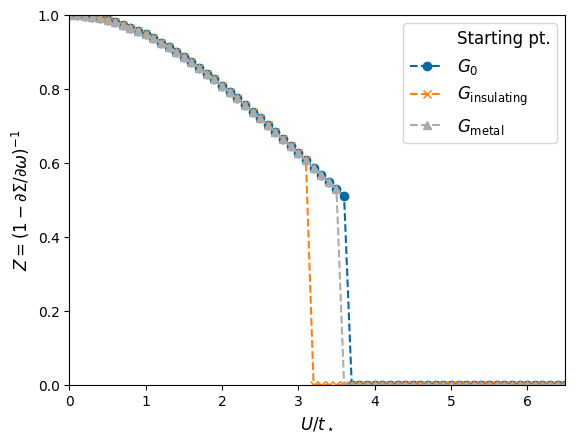

In [12]:
Z_arr_mt = np.empty(U_arr.shape)
Z_arr_in = np.empty(U_arr.shape)

for it in range(len(U_arr)):
    if it != 0:
        solver_mt = DMFT_loop(mesh, solver_mt.g_loc, U_arr[it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
        solver_in = DMFT_loop(mesh, solver_in.g_loc, U_arr[U_num-1-it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
    else:
        solver_mt = DMFT_loop(mesh, g0_loc, U_arr[it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)
        solver_in = DMFT_loop(mesh, g0_loc, U_arr[U_num-1-it], D, sfc_tol=sfc_tol, maxiter=maxiter, mix=mix, verbose=False)

    solver_mt.solve()
    Z = CalcRenormalizationZ(solver_mt)
    Z_arr_mt[it] = Z

    solver_in.solve()
    Z = CalcRenormalizationZ(solver_in)
    Z_arr_in[U_num-1-it] = Z



#%%%%%%%%%%%%%%%% Plot results
plt.figure()
plt.plot([],[],'w',label='Starting pt.')
plt.plot(U_arr, Z_arr, '--o', label='$G_0$')
plt.plot(U_arr, Z_arr_in, '--x', label='$G_{\\mathrm{insulating}}$')
plt.plot(U_arr, Z_arr_mt, '--^', label='$G_{\\mathrm{metal}}$')
ax = plt.gca()
ax.set_xlabel('$U/t_\\star$', fontsize=12)
ax.set_xlim([U_min, U_max])
ax.set_ylabel('$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
ax.set_ylim([0,1])
ax.legend(fontsize=12)
plt.show()

For comparison, we also plotted the transition line where we always start from the non-interacting Green function $G_0$. Since we do only a few iteration steps, we do not have completetly converged solutions, so that the $G_0$ line has a slightly larger critical $U$ value compared to the line which starts from the metallic solution. Try increasinging the parameter `maxiter` (to 1000 or so) and decreasing the parameter `sfc_tol` (to 1e-14 or so) and look at the results! (The lines should become equal.)

Often the energy unit is not the hopping $t_\star$ but the half-bandwidth $D$, so we can also plot the results in this convention:

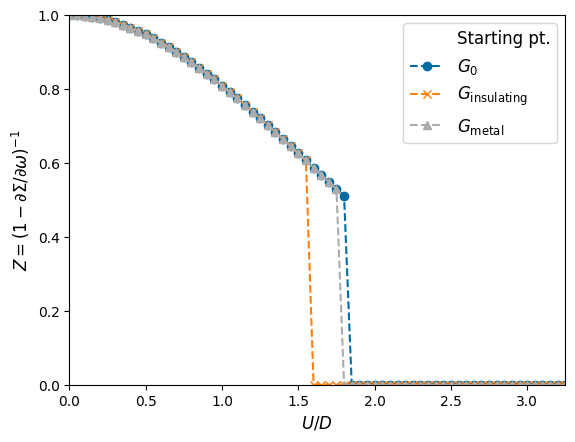

In [13]:
#%%%%%%%%%%%%%%%% Plot results
plt.figure()
plt.plot([],[],'w',label='Starting pt.')
plt.plot(U_arr/D, Z_arr, '--o', label='$G_0$')
plt.plot(U_arr/D, Z_arr_in, '--x', label='$G_{\\mathrm{insulating}}$')
plt.plot(U_arr/D, Z_arr_mt, '--^', label='$G_{\\mathrm{metal}}$')
ax = plt.gca()
ax.set_xlabel('$U/D$', fontsize=12)
ax.set_xlim([U_min/D, U_max/D])
ax.set_ylabel(r'$Z = (1-\partial\Sigma/\partial\omega)^{-1}$', fontsize=12)
ax.set_ylim([0,1])
ax.legend(fontsize=12)
plt.show()